<a href="https://colab.research.google.com/github/hyona-yu/dacon5/blob/master/%EC%83%88%EB%A7%88%EC%9D%8C%EC%83%88%EB%9C%BB_%EC%82%BD%EC%A7%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import tqdm
from sklearn.ensemble import RandomForestRegressor

In [0]:
train_csv = pd.read_csv('./train.csv')
test_csv = pd.read_csv('./test.csv')

In [0]:
columns = train_csv.columns
label_columns = ['hhb','hbo2','ca','na']

In [0]:
train_csv = train_csv.interpolate(method = 'linear', axis = 1)
test_csv = test_csv.interpolate(method=  'linear', axis =1)

In [165]:
test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 72 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       10000 non-null  float64
 1   rho      10000 non-null  float64
 2   650_src  10000 non-null  float64
 3   660_src  10000 non-null  float64
 4   670_src  10000 non-null  float64
 5   680_src  10000 non-null  float64
 6   690_src  10000 non-null  float64
 7   700_src  10000 non-null  float64
 8   710_src  10000 non-null  float64
 9   720_src  10000 non-null  float64
 10  730_src  10000 non-null  float64
 11  740_src  10000 non-null  float64
 12  750_src  10000 non-null  float64
 13  760_src  10000 non-null  float64
 14  770_src  10000 non-null  float64
 15  780_src  10000 non-null  float64
 16  790_src  10000 non-null  float64
 17  800_src  10000 non-null  float64
 18  810_src  10000 non-null  float64
 19  820_src  10000 non-null  float64
 20  830_src  10000 non-null  float64
 21  840_src  1000

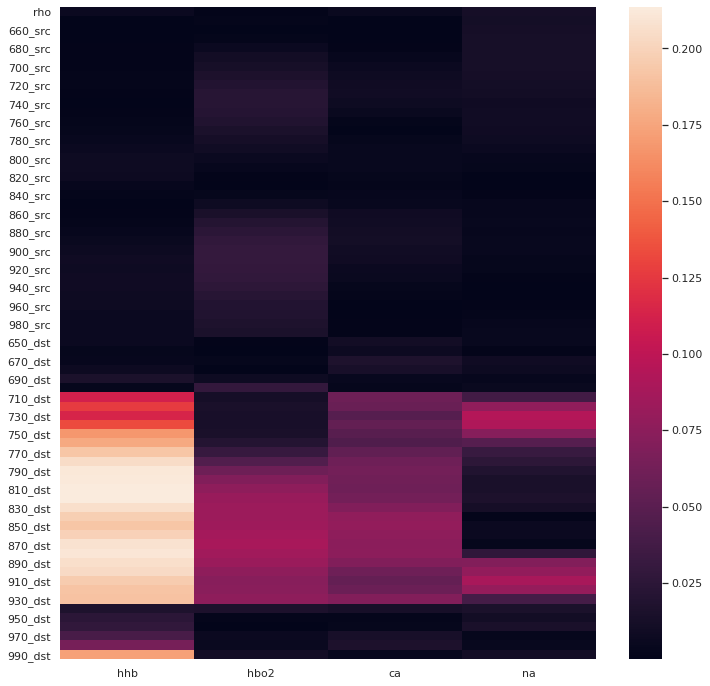

In [156]:
plt.figure(figsize=(12, 12))
sns.heatmap(train_csv.corr().loc['rho':'990_dst', 'hhb':].abs())

In [0]:
#plt.figure(figsize=(12, 12))
#sns.heatmap(train_csv.corr().loc['rho':'990_dst', 'rho':'990_dst'].abs())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

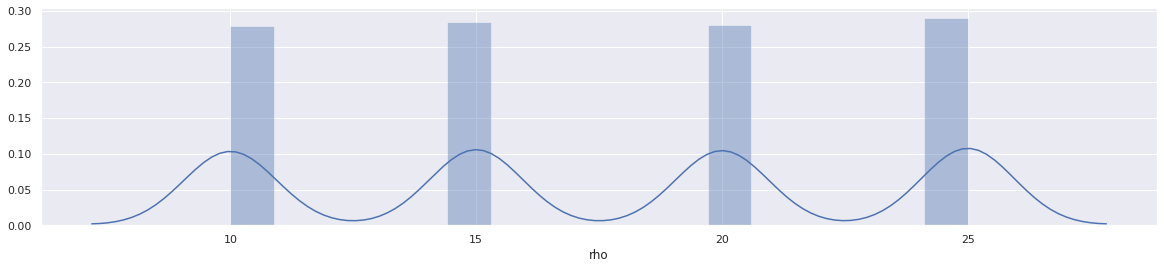

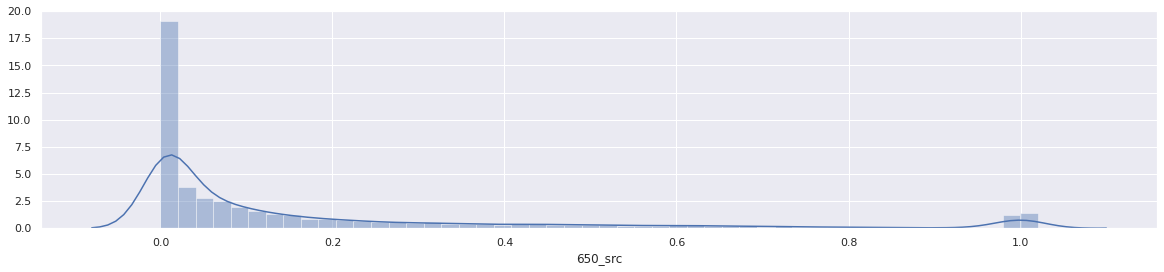

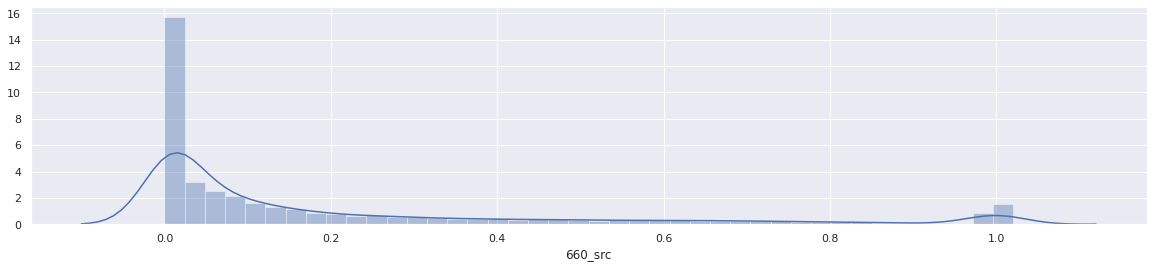

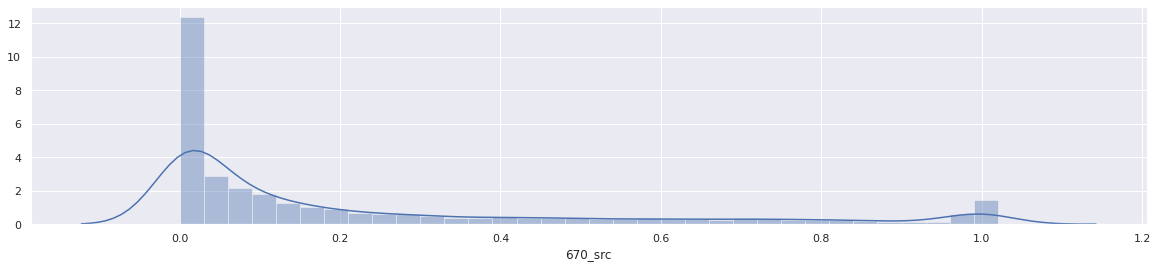

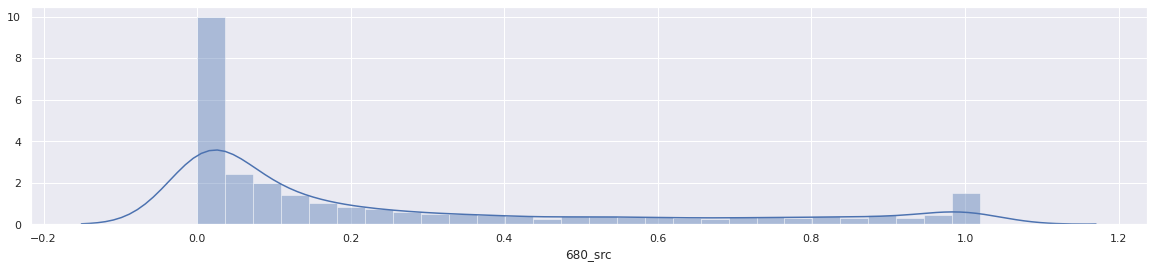

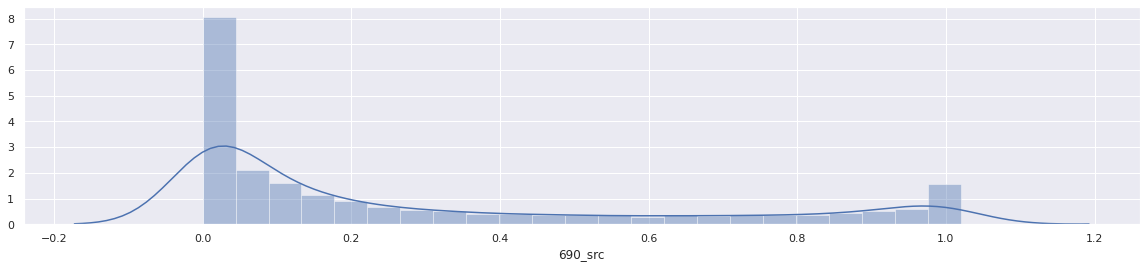

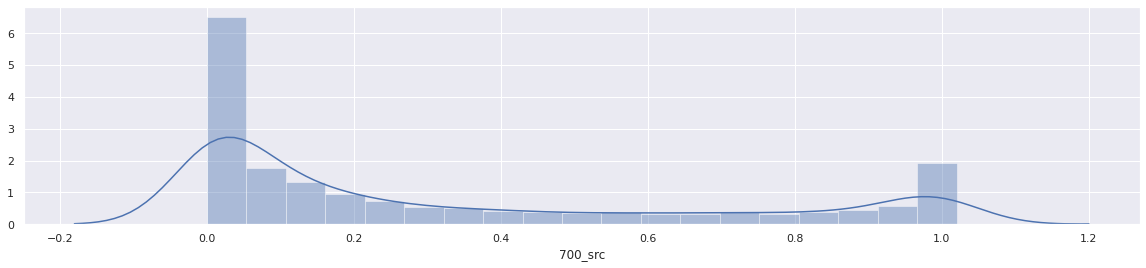

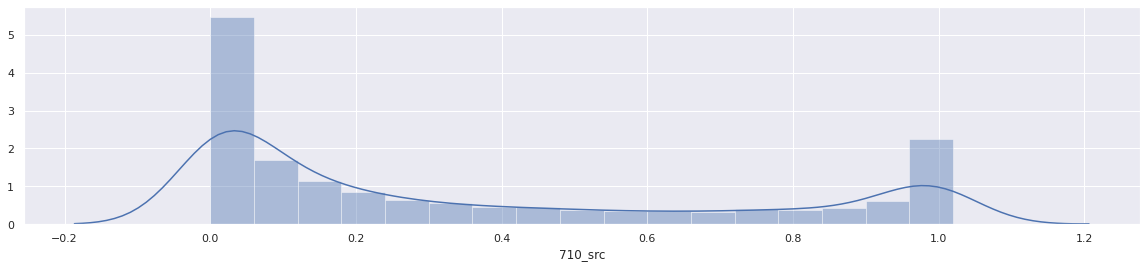

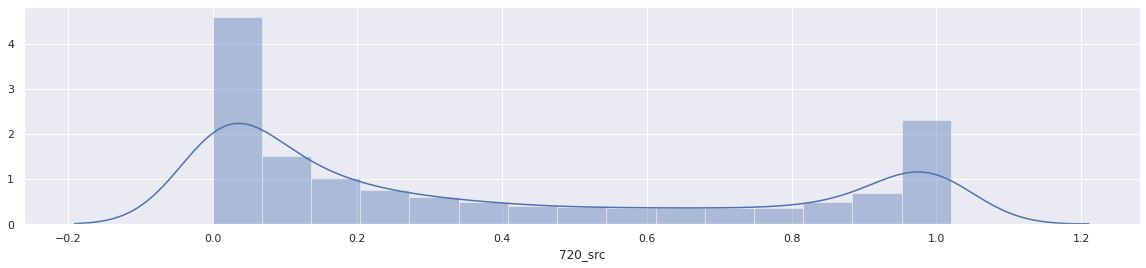

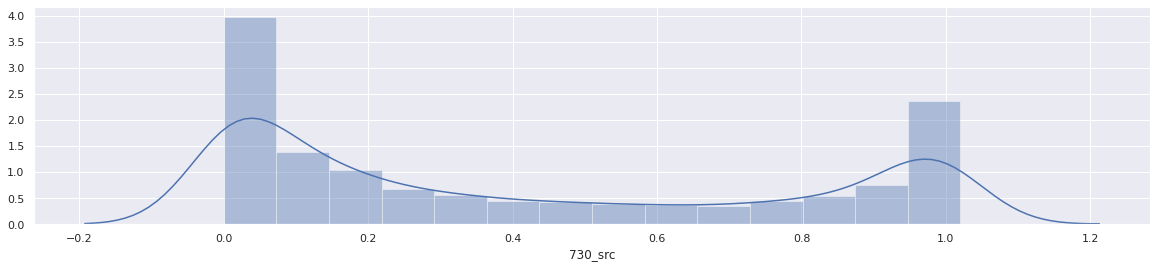

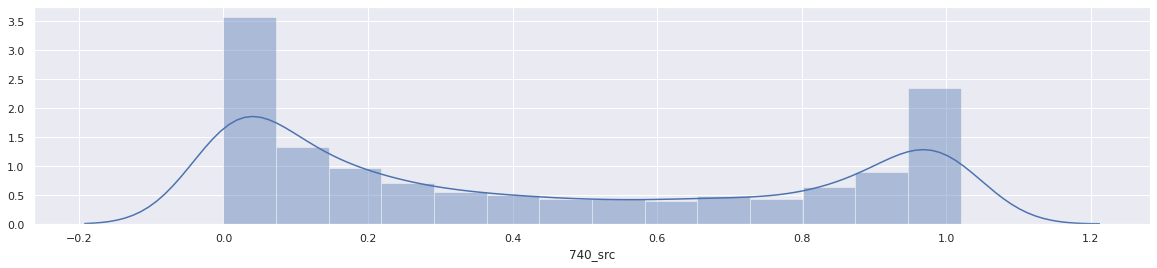

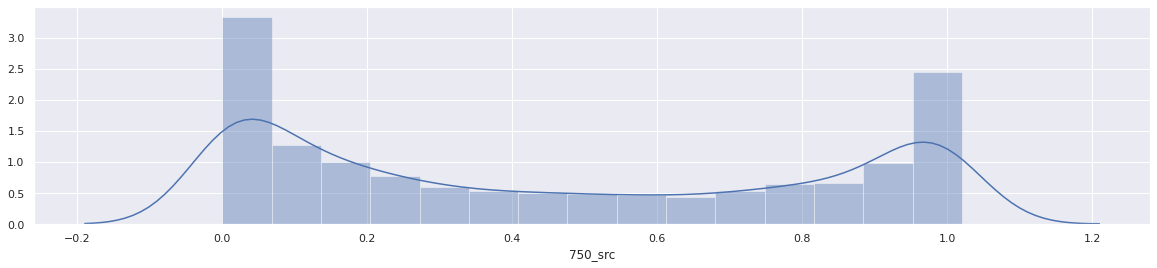

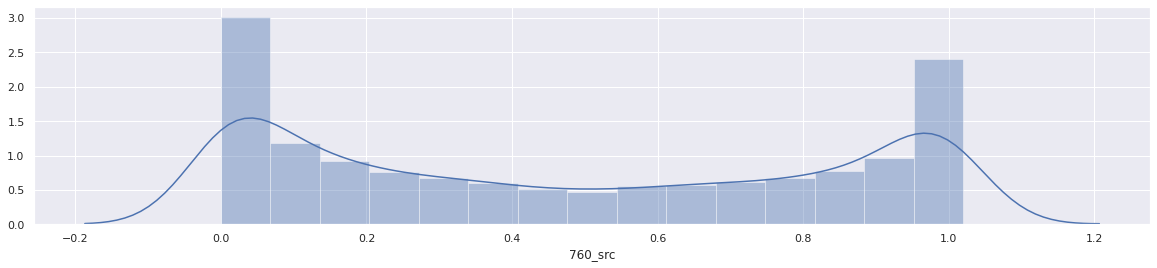

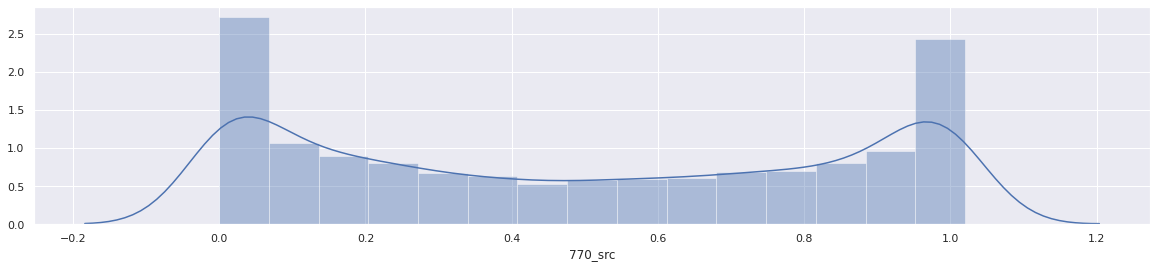

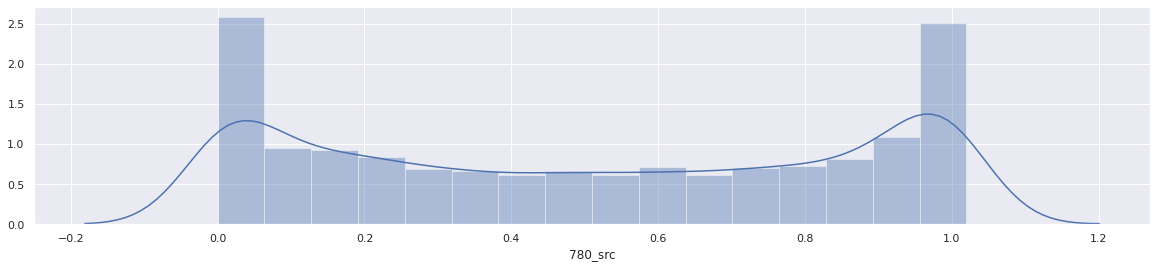

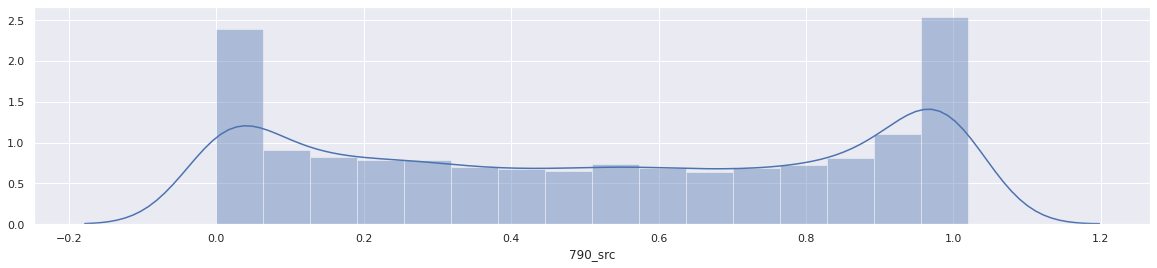

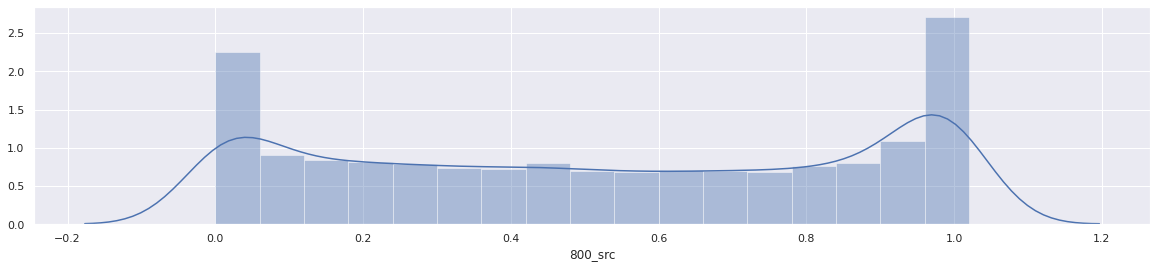

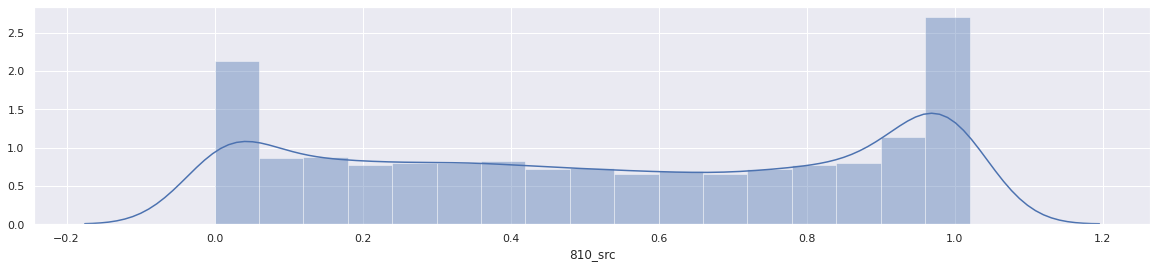

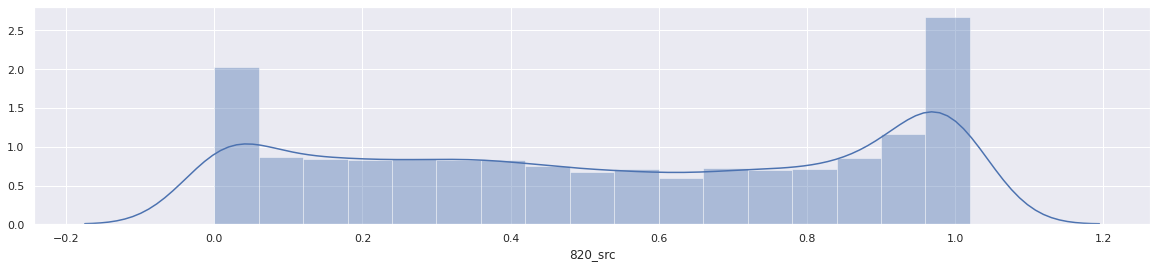

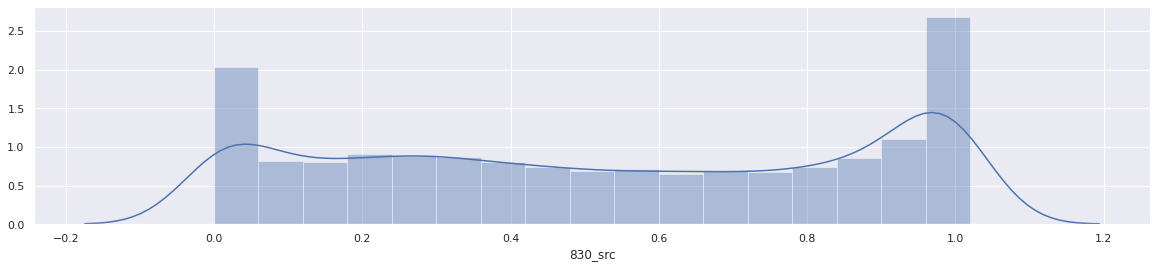

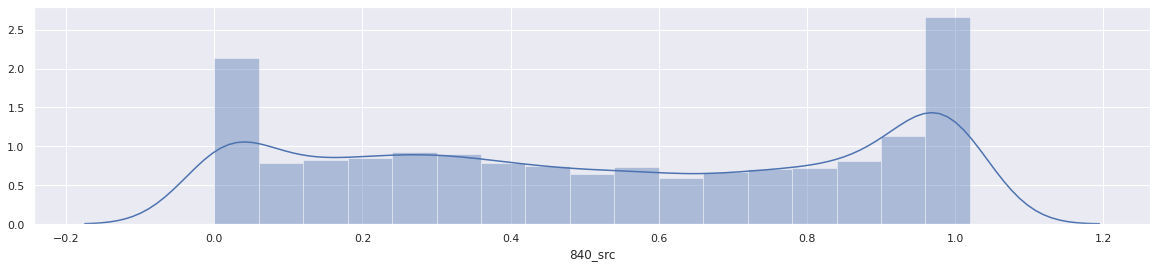

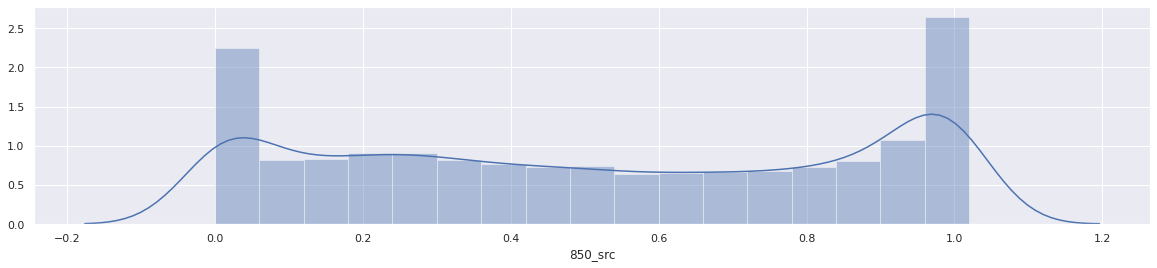

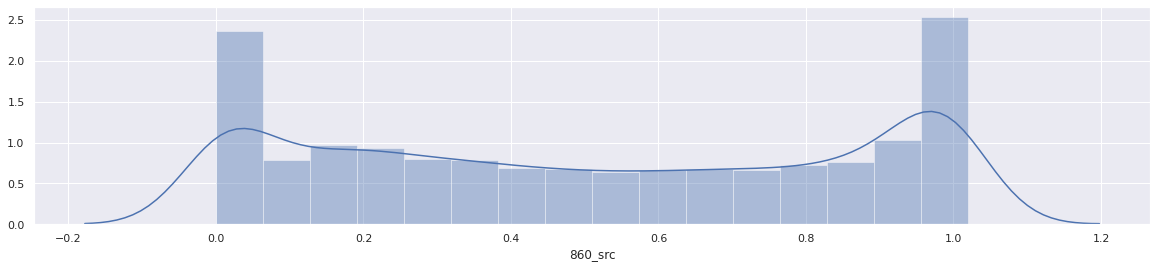

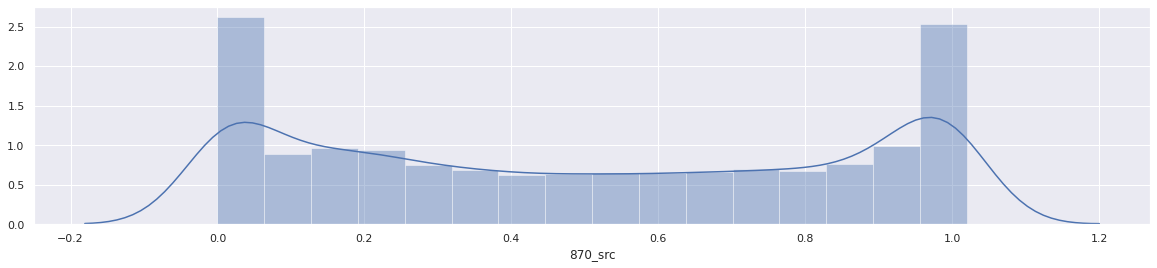

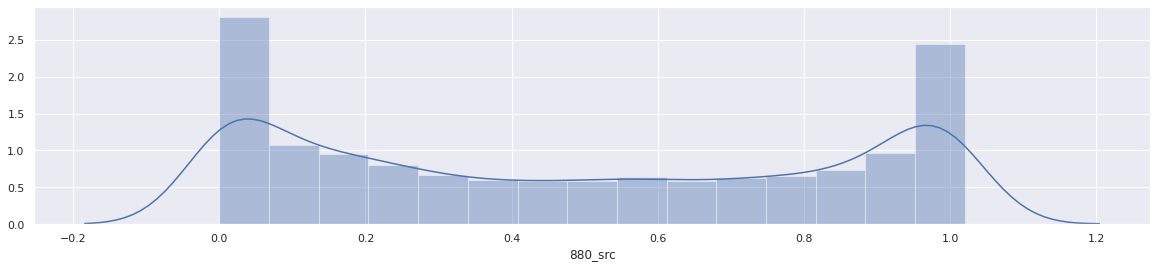

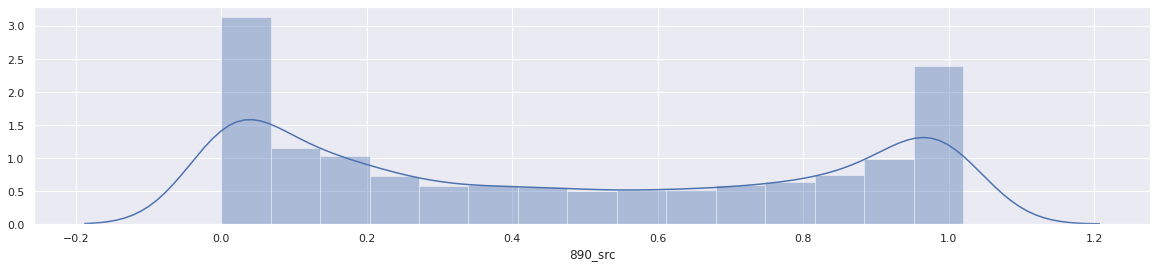

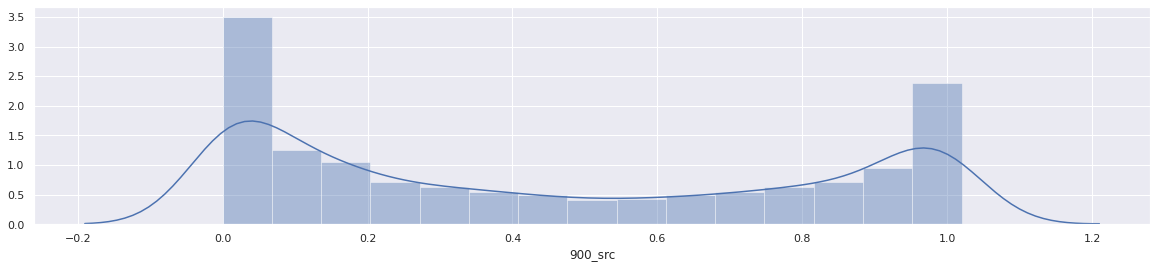

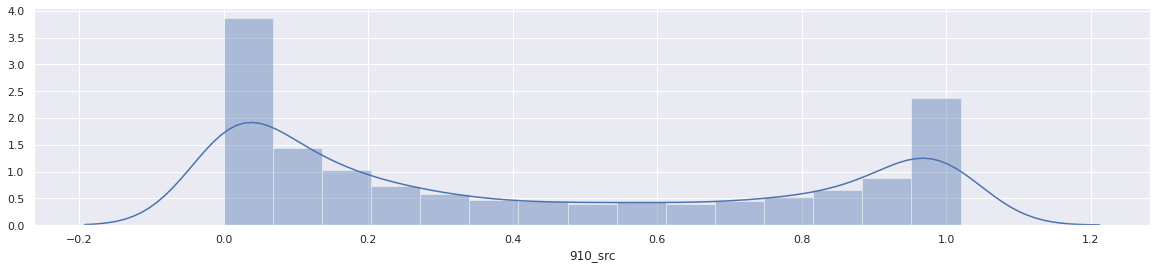

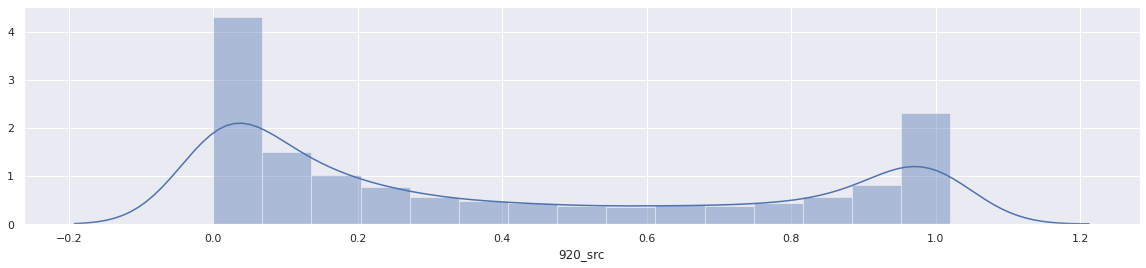

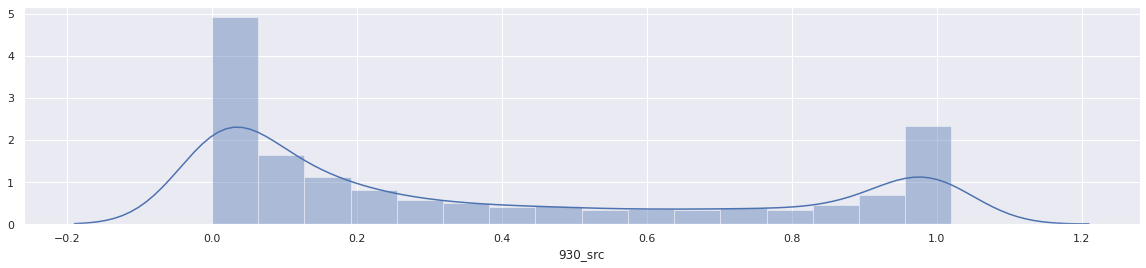

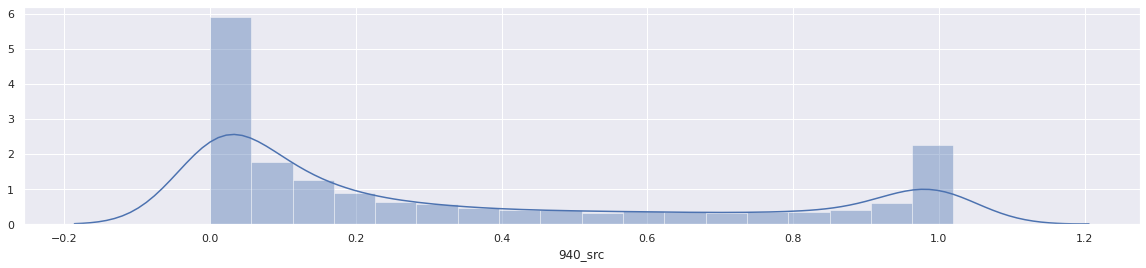

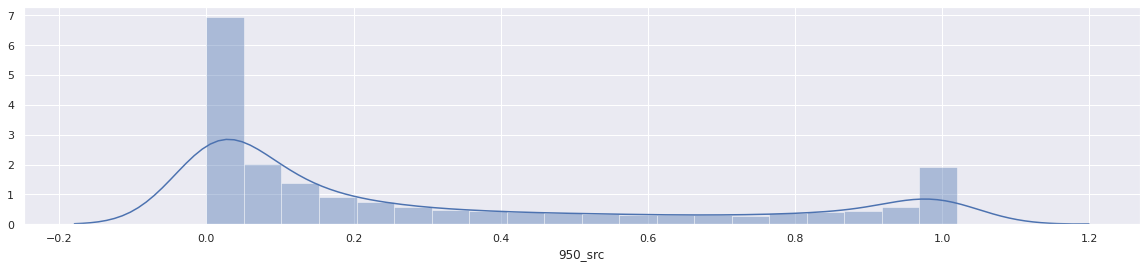

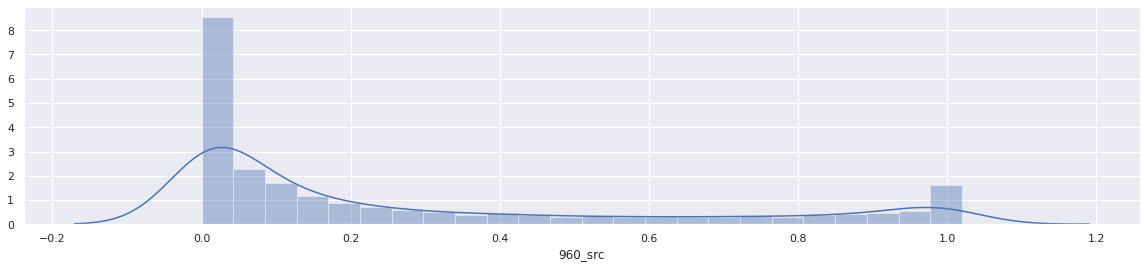

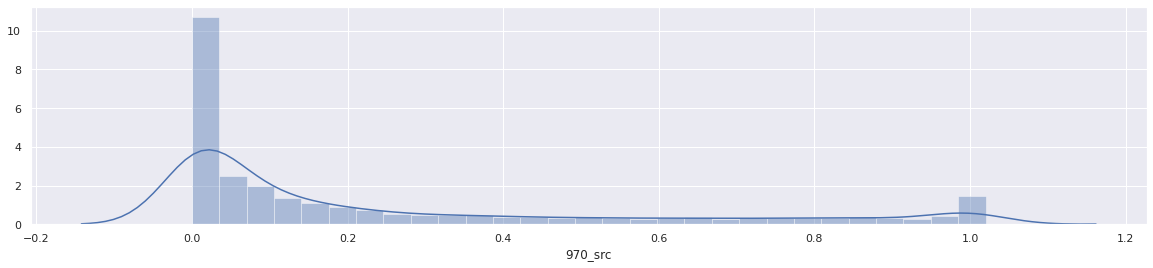

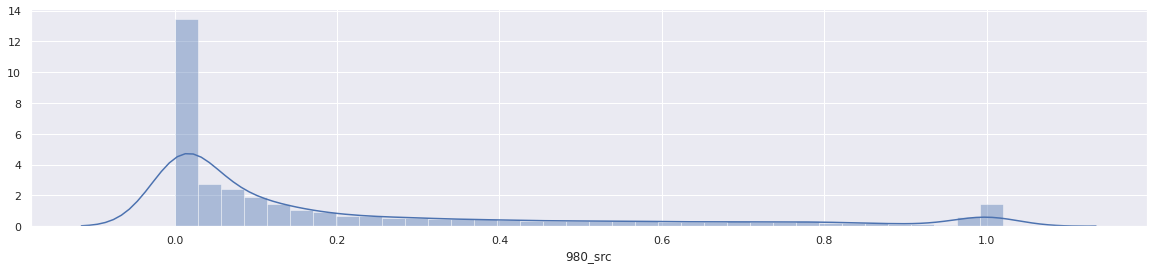

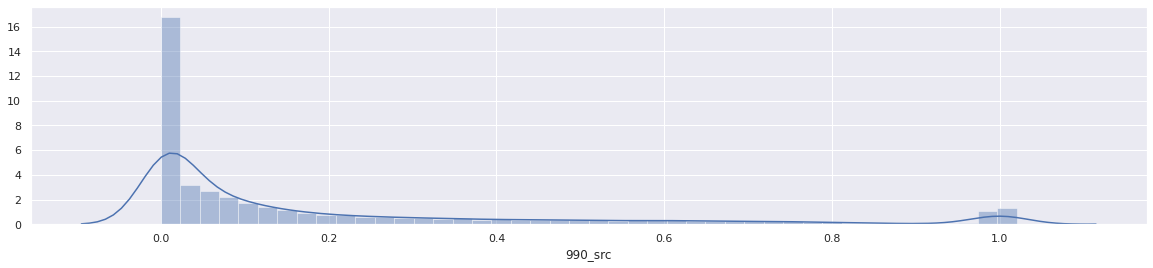

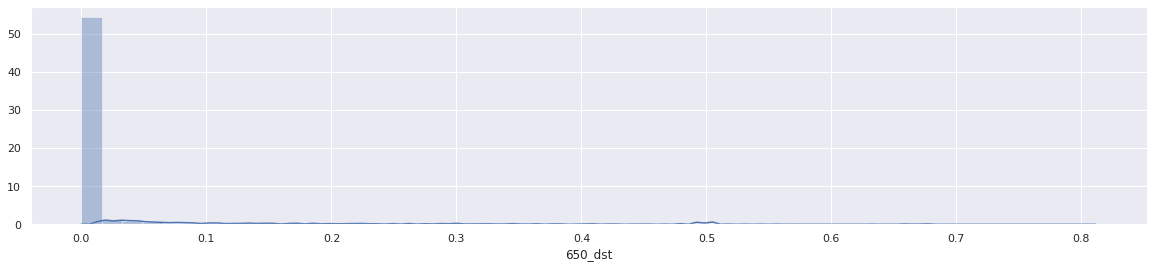

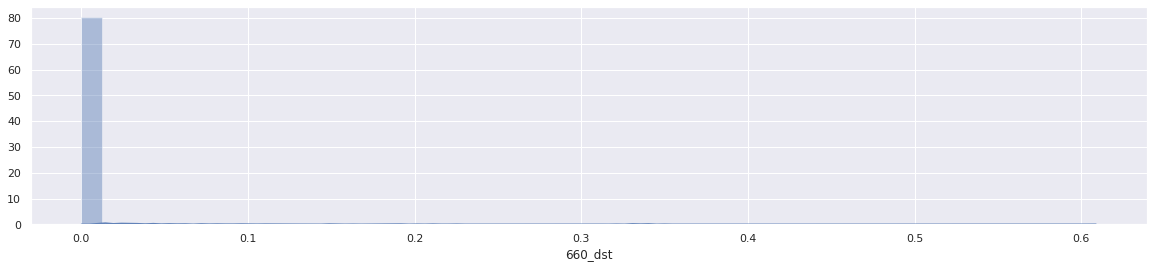

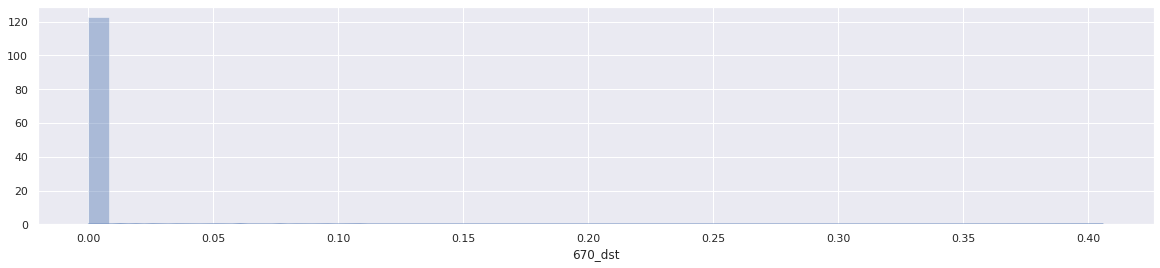

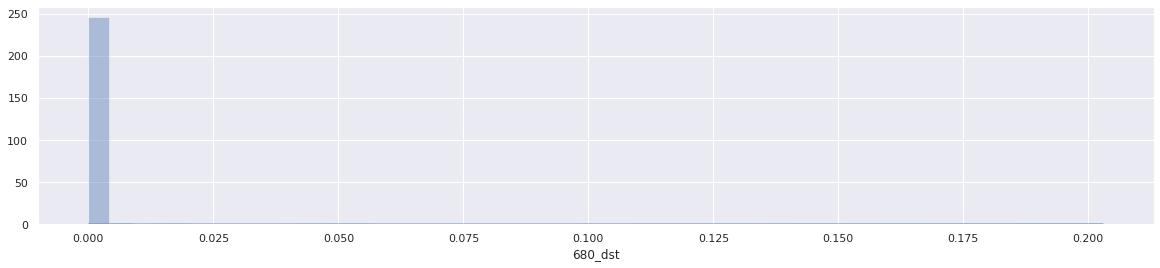

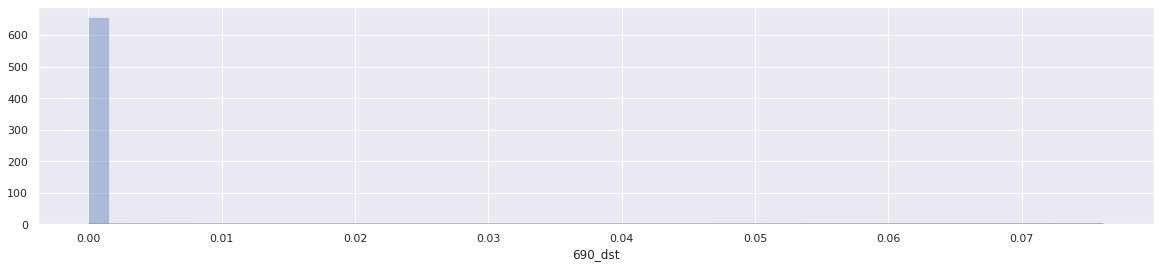

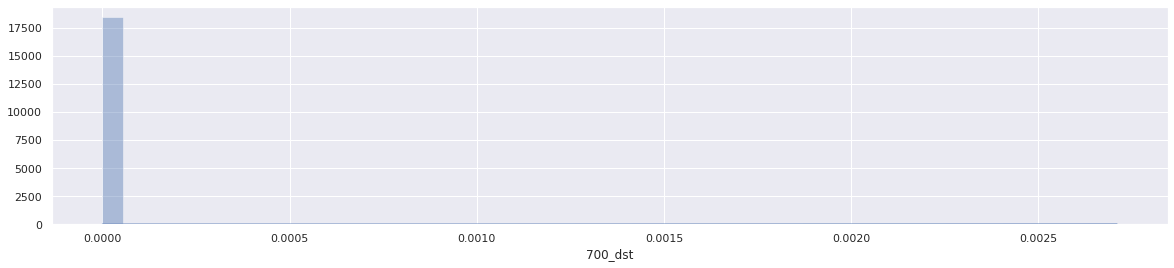

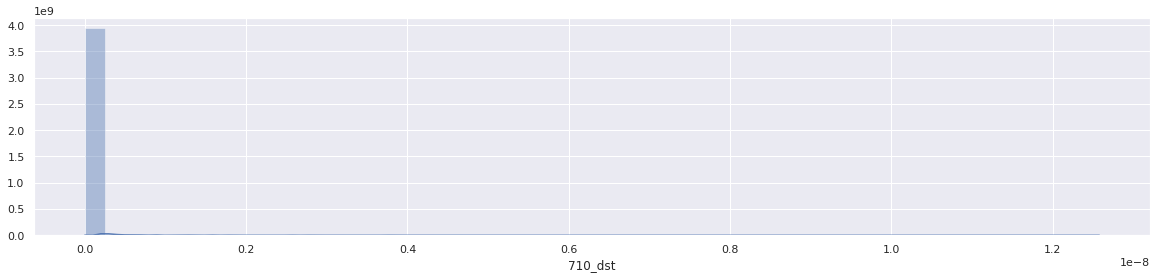

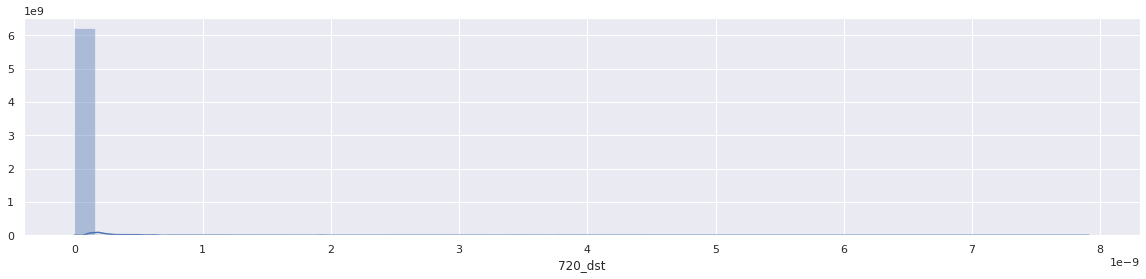

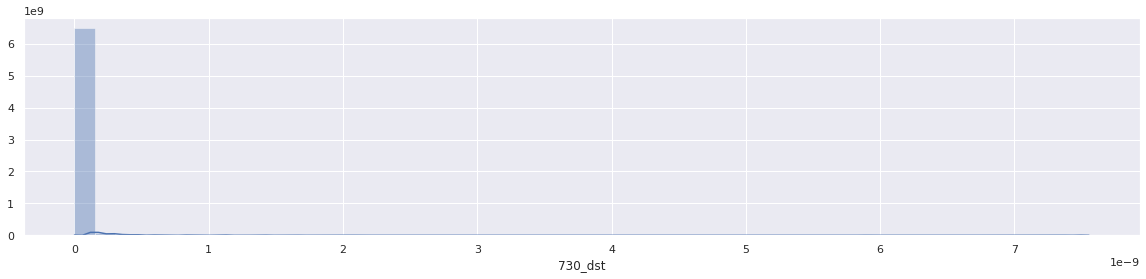

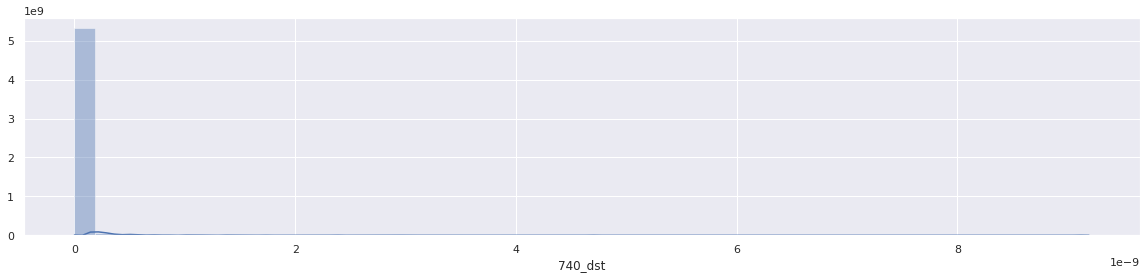

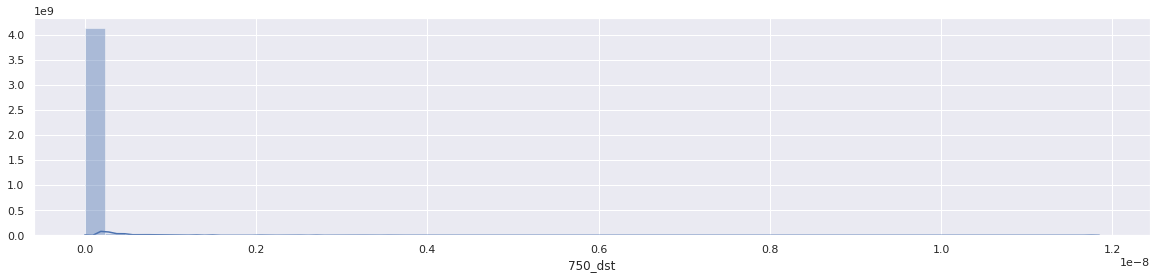

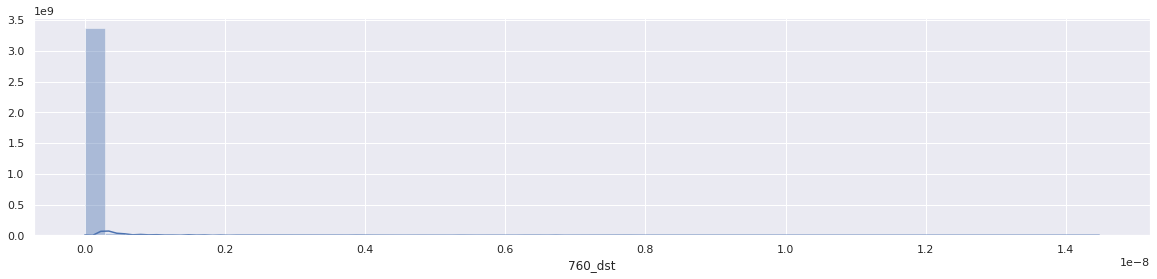

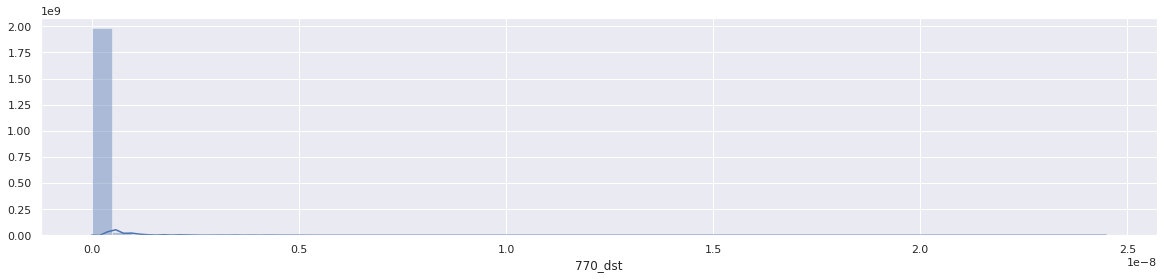

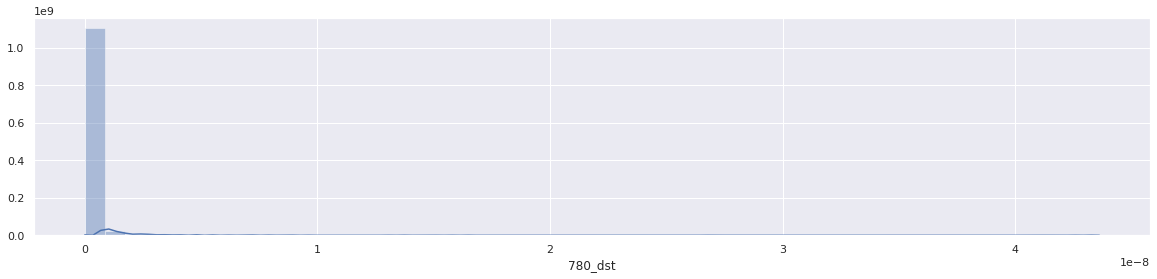

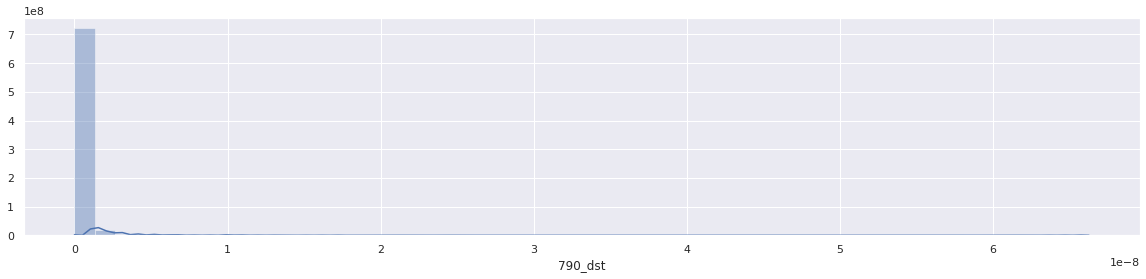

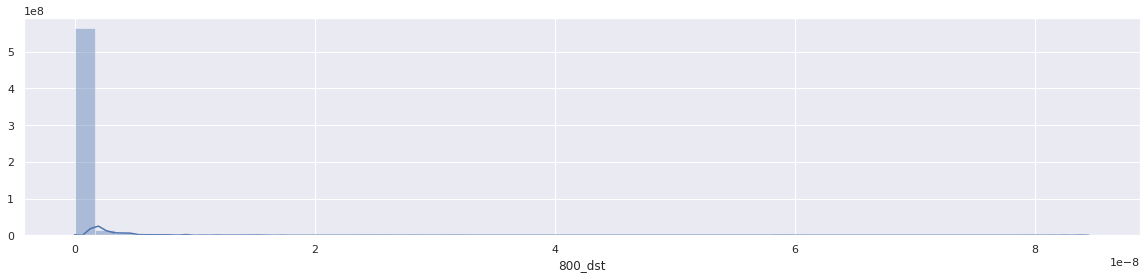

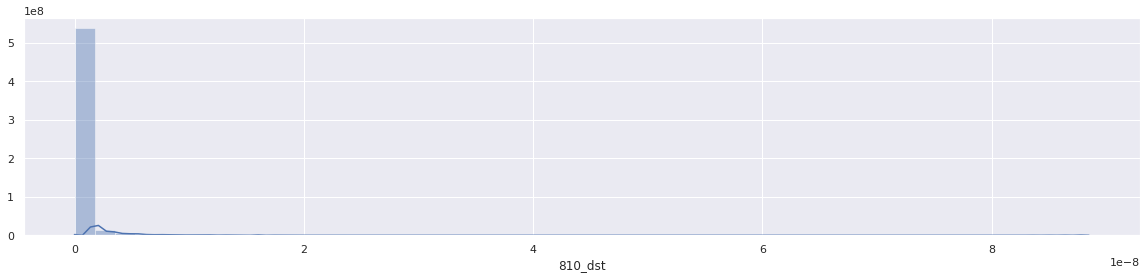

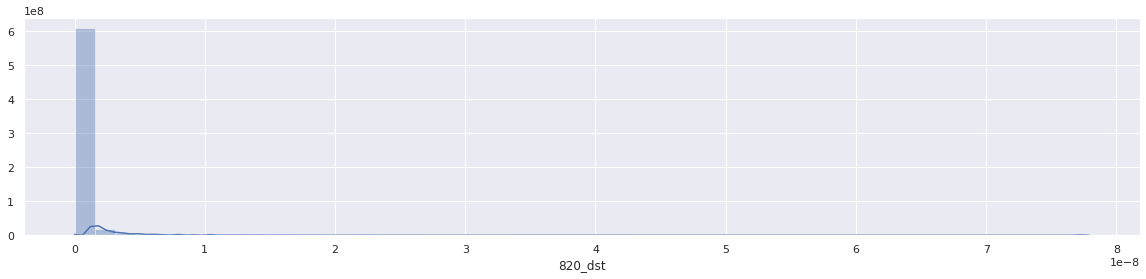

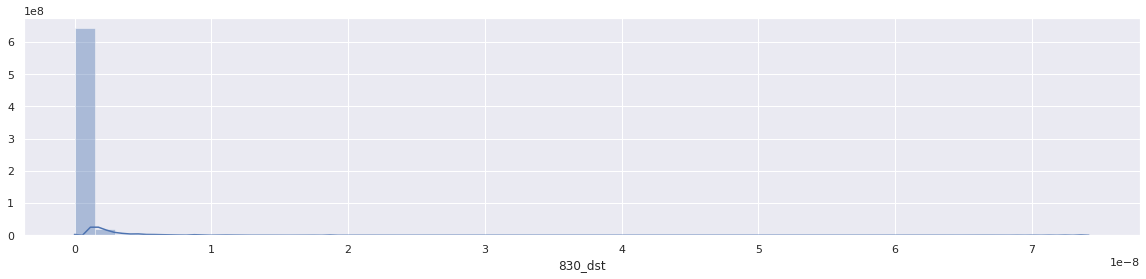

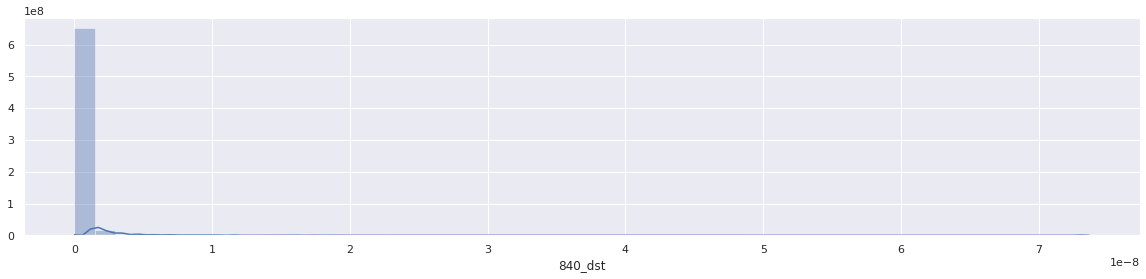

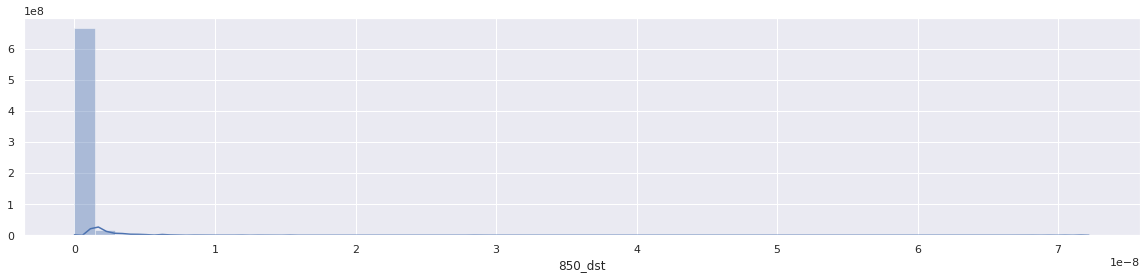

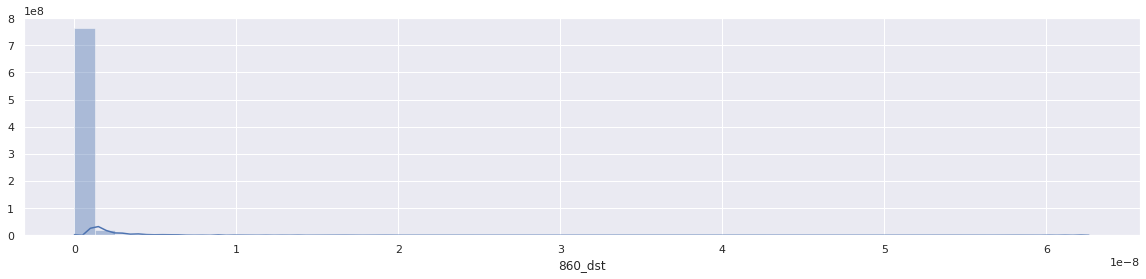

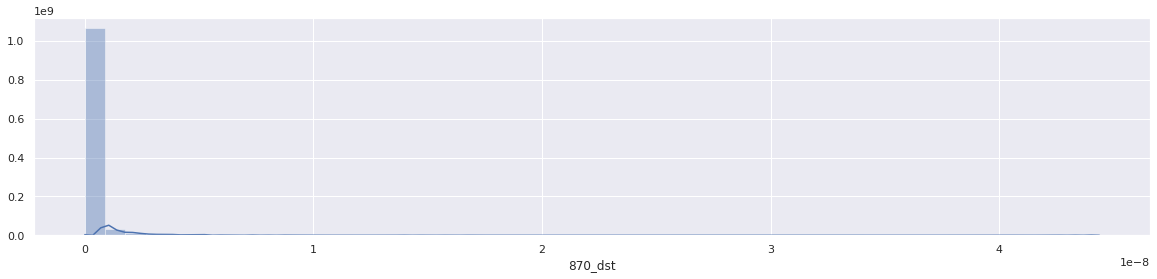

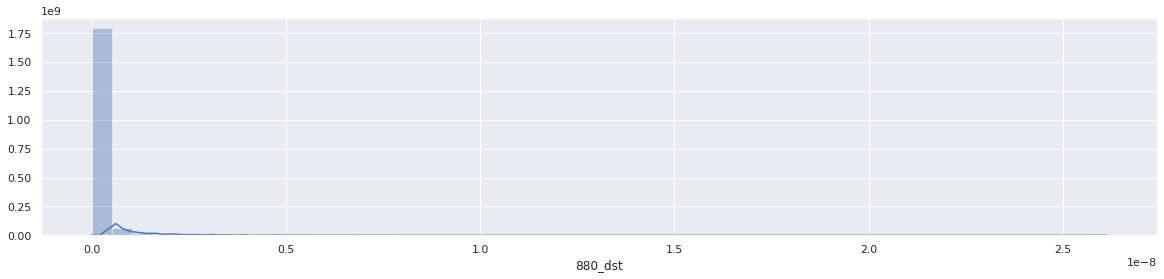

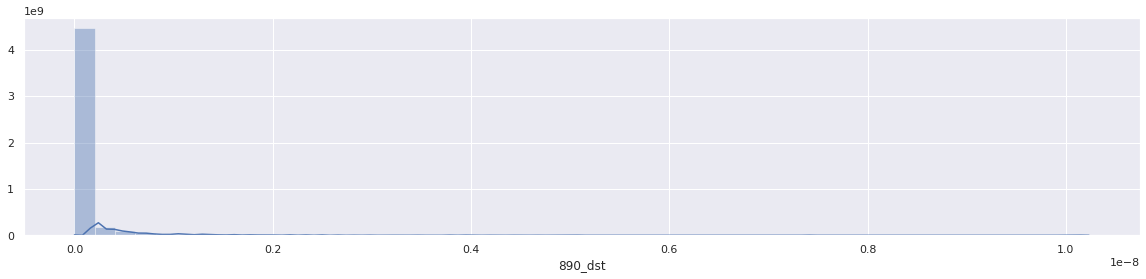

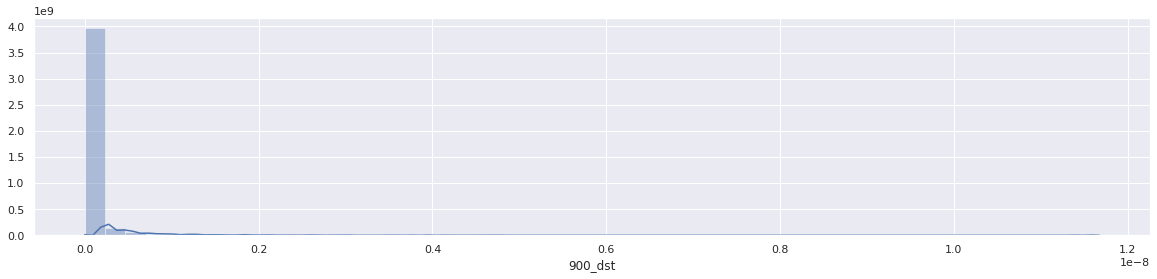

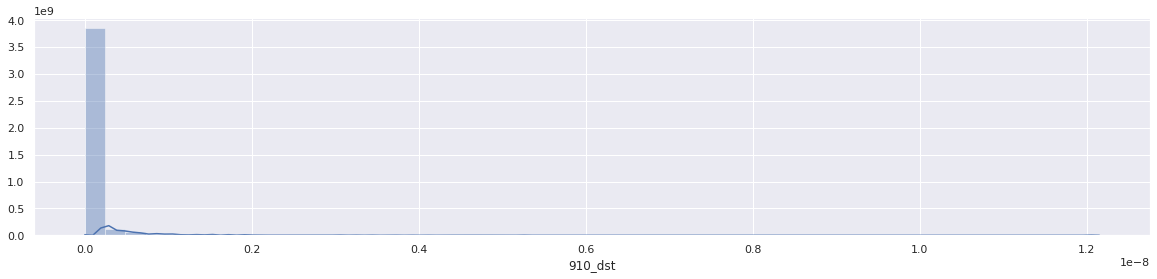

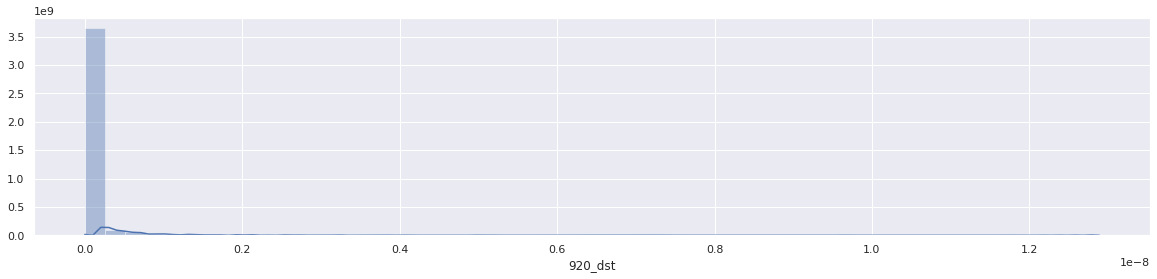

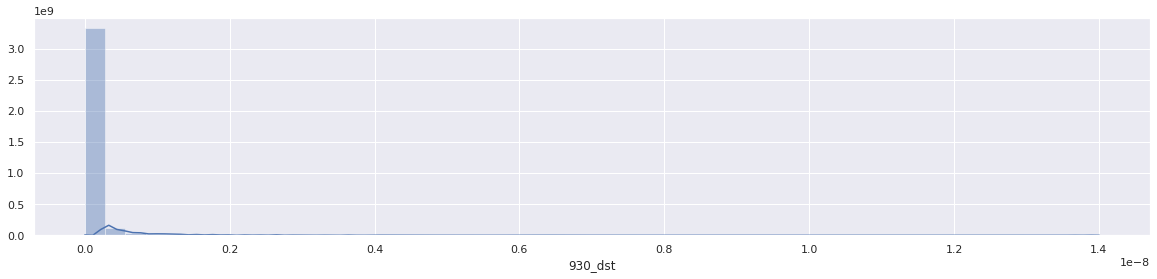

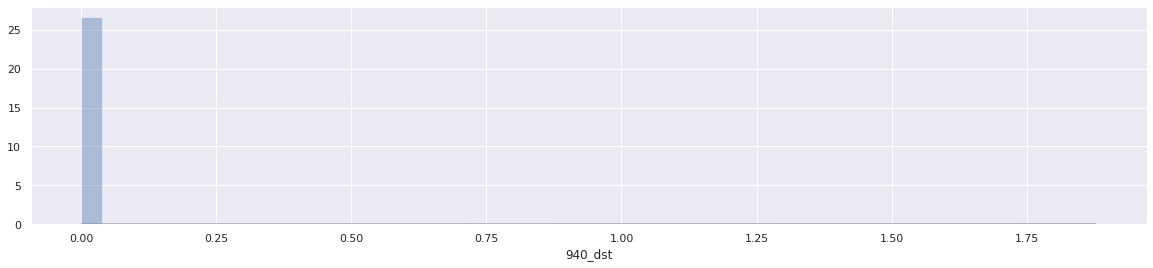

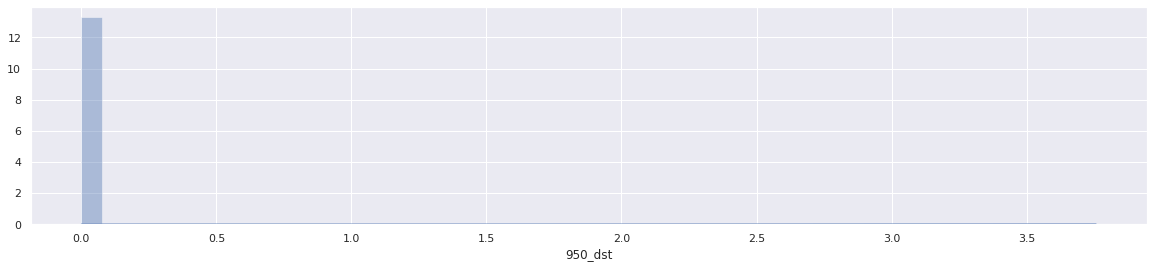

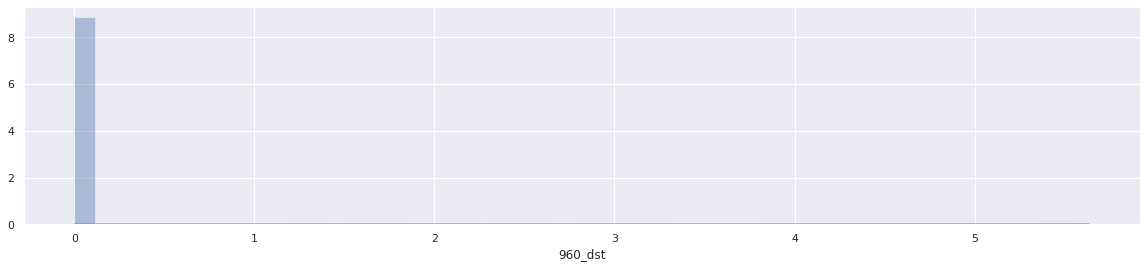

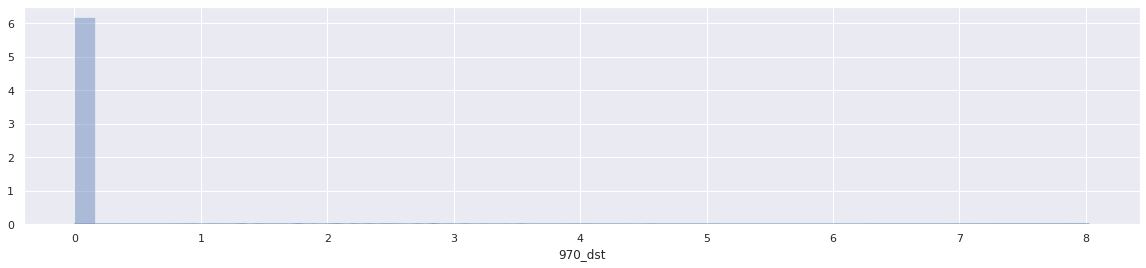

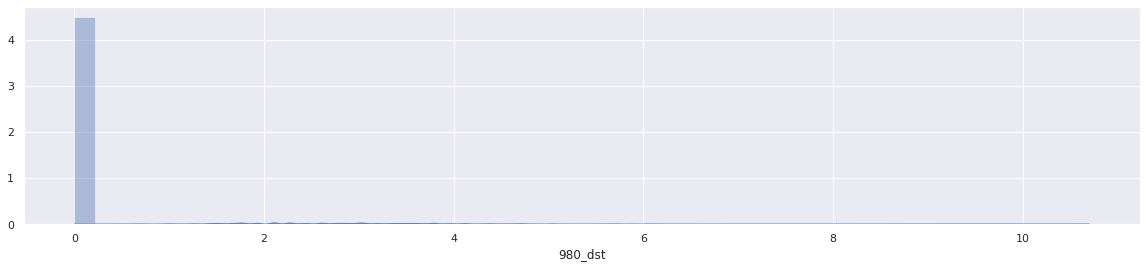

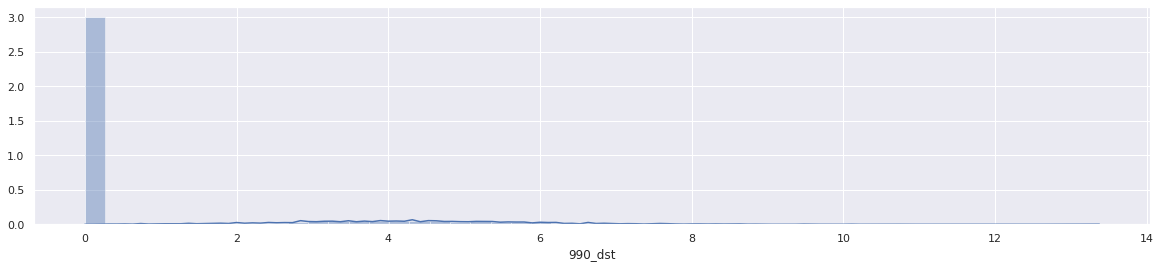

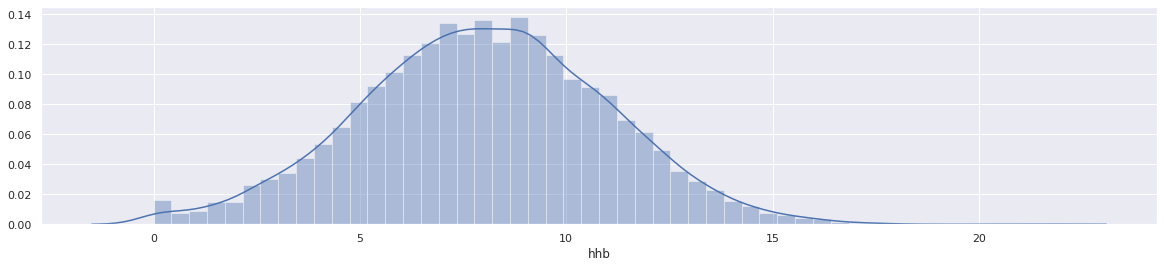

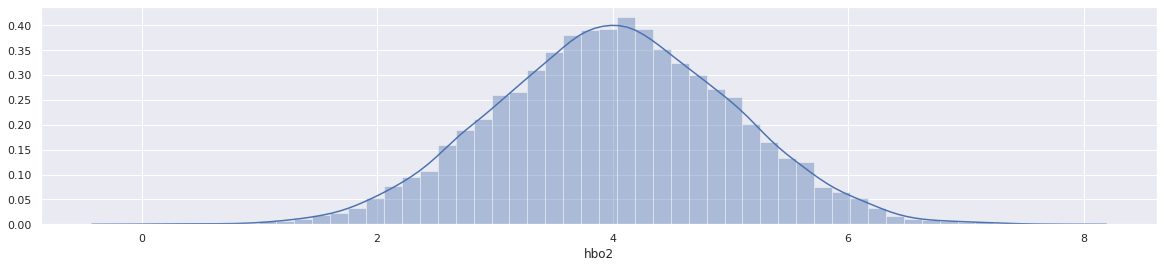

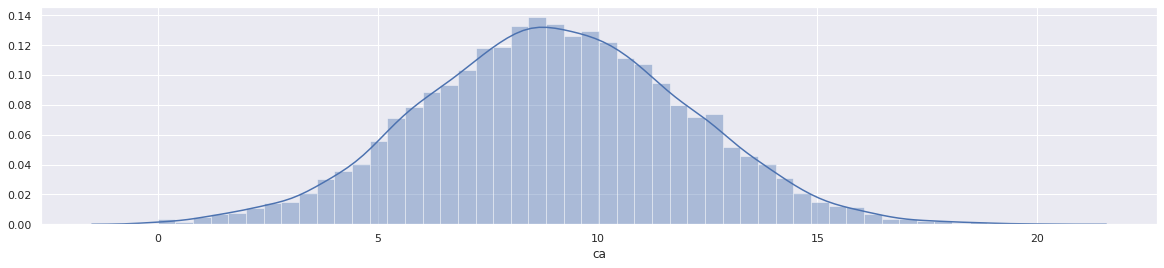

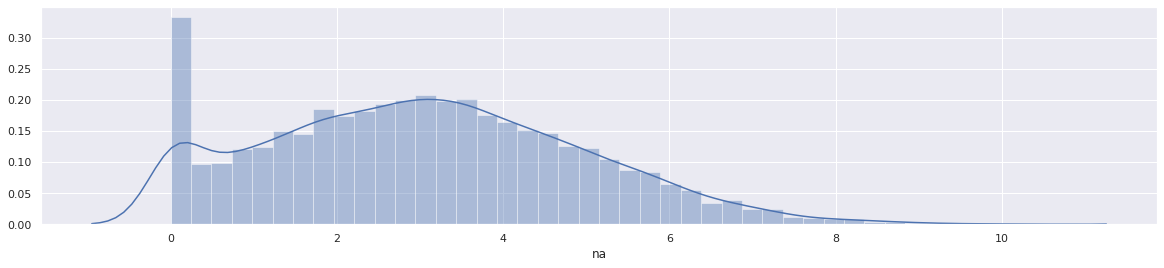

In [0]:
sns.set()
for c in columns[1:]:
    fig,ax = plt.subplots(1,1, figsize= (20,4))
    sns.distplot(train_csv[c])

In [0]:
new_test_csv = test_csv.drop(columns= ["id"],axis = 1)
new_train_csv = train_csv.drop(columns = label_columns, axis = 1).drop(columns = ['id'], axis = 1)

In [0]:
for start, fin in zip(["650_dst","720_dst","780_dst","890_dst", "930_dst"],["710_dst","770_dst","880_dst","940_dst", "990_dst"]):
  avg = []
  for i in range(len(train_csv)):
    avg.append(train_csv.loc[i, start:fin].mean())
  train_csv[f'{start}_{fin}_dst'] = avg

In [0]:
#test data
for start, fin in zip(["650_dst","720_dst","780_dst","890_dst", "930_dst"],["710_dst","770_dst","880_dst","940_dst","990_dst"]):
  avg = []
  for i in range(len(test_csv)):
    avg.append(test_csv.loc[i, start:fin].mean())
  test_csv[f'{start}_{fin}_dst'] = avg


In [169]:
new_train_csv

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,25.0,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,1.098559e-17,8.907142e-19,4.453571e-19,0.000000e+00,0.000000e+00,0.000000e+00,5.901745e-18,3.539278e-18,1.176812e-18,2.837586e-17,5.557492e-17,1.046498e-16,8.850865e-17,7.236748e-17,4.021610e-17,2.397489e-17,1.870153e-17,1.808920e-17,9.044602e-18,0.000000e+00,2.626216e-18,3.076794e-18,3.527371e-18,2.086464e-18,6.455564e-19,3.227782e-19,0.000000e+00,5.337522e-19,1.067504e-18,5.998949e-18,4.378513e-17
1,10.0,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.151021e-10,4.318673e-10,2.753933e-10,0.000000e+00,8.138830e-10,6.522110e-10,4.627171e-10,2.732232e-10,1.749279e-10,7.663267e-11,1.077911e-10,1.389496e-10,1.472282e-09,1.450463e-09,1.225321e-09,2.647633e-09,3.940557e-09,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,5.920319e-09,9.710091e-09,4.855046e-09
2,25.0,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,1.881795e-20,0.000000e+00,2.993884e-19,5.987767e-19,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,3.349335e-19,1.674668e-19,0.000000e+00,2.630961e-18,1.315480e-18,0.000000e+00,9.912979e-18,1.112747e-17,8.377108e-18,5.626746e-18,2.876385e-18,1.260239e-19,6.301194e-20,0.000000e+00,3.876159e-18,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,5.320000e+00
3,10.0,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,4.695169e-11,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,7.958742e-11,1.583839e-10,1.630944e-10,1.678049e-10,2.814419e-10,4.429321e-10,1.319956e-09,2.269806e-09,2.679164e-09,2.538200e-09,2.046841e-09,1.516820e-09,1.328007e-09,1.061359e-09,8.634016e-10,5.804951e-10,3.615067e-10,2.444971e-10,1.274876e-10,6.118947e-11,1.137891e-10,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,2.433592e-10,4.088921e-10,2.835000e+00
4,15.0,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98270,1.00432,1.01434,1.01455,0.98861,0.98300,1.00616,0.99045,1.01321,1.01559,1.01072,0.99439,0.98597,0.99889,1.01412,4.784751e-14,2.392375e-14,0.000000e+00,1.153089e-13,0.000000e+00,0.000000e+00,1.056991e-13,0.000000e+00,0.000000e+00,2.666663e-14,1.493071e-14,7.465355e-15,0.000000e+00,1.200730e-1

In [170]:
columns[37]

'650_dst'

In [0]:
for i in range(2, 37):
  new_train_csv[f'{i}st_sub'] = new_train_csv[columns[i]] - new_train_csv[columns[i+35]]
  new_test_csv[f'{i}st_sub'] = new_test_csv[columns[i]] - new_test_csv[columns[i+35]]

In [172]:
new_train_csv

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,...,950_dst,960_dst,970_dst,980_dst,990_dst,2st_sub,3st_sub,4st_sub,5st_sub,6st_sub,7st_sub,8st_sub,9st_sub,10st_sub,11st_sub,12st_sub,13st_sub,14st_sub,15st_sub,16st_sub,17st_sub,18st_sub,19st_sub,20st_sub,21st_sub,22st_sub,23st_sub,24st_sub,25st_sub,26st_sub,27st_sub,28st_sub,29st_sub,30st_sub,31st_sub,32st_sub,33st_sub,34st_sub,35st_sub,36st_sub
0,25.0,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,...,0.000000e+00,5.337522e-19,1.067504e-18,5.998949e-18,4.378513e-17,3.795000e-01,0.42993,0.52076,5.716600e-01,6.781800e-01,0.75476,0.83580,0.93623,0.96333,1.01541,9.986500e-01,0.94373,8.451300e-01,0.74023,0.68776,0.57697,0.51536,4.350800e-01,3.650100e-01,3.493500e-01,3.003800e-01,2.699200e-01,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,1.078600e-01,0.11984,0.09851,1.096500e-01,0.07424,0.07777,0.05536
1,10.0,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,...,6.112685e-09,2.130547e-09,5.920319e-09,9.710091e-09,4.855046e-09,0.000000e+00,0.00000,0.01813,-1.995530e-10,-1.025259e-10,0.01974,0.00321,0.00000,0.00000,0.01295,-1.151021e-10,0.01565,-2.753933e-10,0.00000,0.01285,0.01129,0.00359,-2.732232e-10,-1.749279e-10,-7.663267e-11,-1.077911e-10,-1.389496e-10,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,9.748000e-01,0.99803,0.97146,8.704500e-01,0.75330,0.63414,0.53699
2,25.0,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,1.881795e-20,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,5.320000e+00,-1.677445e-19,0.03289,0.02416,3.610000e-02,5.843000e-02,0.09015,0.14944,0.18578,0.25584,0.30445,3.896200e-01,0.50472,5.693400e-01,0.67742,0.79720,0.87593,0.92783,9.949800e-01,9.868200e-01,9.898800e-01,9.510100e-01,8.985300e-01,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,1.907000e-01,0.16603,0.11617,6.744000e-02,0.02343,0.03926,-5.28864
3,10.0,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,4.695169e-11,5.345363e-11,9.106886e-12,...,1.299511e-10,7.782625e-11,2.433592e-10,4.088921e-10,2.835000e+00,2.750300e-01,0.31281,0.32898,4.104100e-01,4.658700e-01,0.52769,0.64369,0.73562,0.79865,0.91482,9.527400e-01,0.99391,1.005630e+00,0.93165,0.84703,0.74997,0.67765,5.843200e-01,5.064200e-01,4.308700e-01,3.568400e-01,3.078600e-01,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,1.339200e-01,0.14247,0.10126,9.928000e-02,0.09239,0.10523,-2.77151
4,15.0,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98270,1.00432,1.01434,1.01455,0.98861,0.98300,1.00616,0.99045,1.01321,1.01559,1.01072,0.99439,0.98597,0.99889,1.01412,4.784751e-14,2.392375e-14,0.000000e+00,1.

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler=  StandardScaler()
Mscaler = MinMaxScaler()
new_train_csv[columns[37:72]] = Mscaler.fit_transform(new_train_csv[columns[37:72]])
new_test_csv[columns[37:72]] = Mscaler.transform(new_test_csv[columns[37:72]])
new_train_csv[columns[2:37]] = scaler.fit_transform(new_train_csv[columns[2:37]])
new_test_csv[columns[2:37]] = scaler.transform(new_test_csv[columns[2:37]])
new_train_csv[new_train_csv.columns[-35:]] = Mscaler.fit_transform(new_train_csv[new_train_csv.columns[-35:]])
new_test_csv[new_train_csv.columns[-35:]] = Mscaler.transform(new_test_csv[new_train_csv.columns[-35:]])
# new_train_csv[columns[2:72]]=scaler.fit_transform(new_train_csv[columns[2:72]]) #이거 별차이는 없음
# new_test_csv[columns[2:72]] =scaler.transform(new_test_csv[columns[2:72]])

In [0]:
 #pd.DataFrame(pca.fit_transform(new_train_csv[columns[37:72]]))

In [175]:
new_train_csv

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,...,950_dst,960_dst,970_dst,980_dst,990_dst,2st_sub,3st_sub,4st_sub,5st_sub,6st_sub,7st_sub,8st_sub,9st_sub,10st_sub,11st_sub,12st_sub,13st_sub,14st_sub,15st_sub,16st_sub,17st_sub,18st_sub,19st_sub,20st_sub,21st_sub,22st_sub,23st_sub,24st_sub,25st_sub,26st_sub,27st_sub,28st_sub,29st_sub,30st_sub,31st_sub,32st_sub,33st_sub,34st_sub,35st_sub,36st_sub
0,25.0,0.730404,0.784356,0.949828,0.962038,1.133961,1.209218,1.300369,1.455641,1.440823,1.518359,1.435580,1.259890,0.967302,0.653989,0.488295,0.156678,-0.031341,-0.267304,-0.466970,-0.499655,-0.619109,-0.674304,-0.741193,-0.724096,-0.724541,-0.807714,-0.777074,-0.728394,-0.704714,-0.604505,-0.596792,-0.500250,-0.544647,-0.475339,-0.495426,3.015579e-18,3.112100e-18,0.000000e+00,3.160222e-17,...,0.000000e+00,9.470887e-20,1.330223e-19,5.606494e-19,3.273655e-18,0.608370,0.591252,0.594343,0.571267,6.648824e-01,0.739983,0.819436,9.179265e-01,9.444504e-01,0.995529,9.790686e-01,0.925271,0.828567,7.257442e-01,0.674433,0.565679,0.505290,0.426570,0.357860,3.425168e-01,2.944960e-01,0.264638,0.227399,0.215673,0.195302,1.420924e-01,0.128928,0.121985,1.057461e-01,0.525850,0.755340,0.854842,0.894067,0.919031,0.932565
1,10.0,-0.660493,-0.705114,-0.691011,-0.797819,-0.847026,-0.845735,-0.947247,-1.014398,-1.079002,-1.112416,-1.215960,-1.243074,-1.348723,-1.405789,-1.417607,-1.455597,-1.500263,-1.521559,-1.521918,-1.505828,-1.478590,-1.438552,-1.263470,-1.032340,-0.678165,-0.093998,0.549586,1.154481,1.595092,1.775103,1.853599,1.746627,1.581476,1.383250,1.216150,0.000000e+00,0.000000e+00,0.000000e+00,9.833784e-10,...,1.626950e-09,3.780438e-10,7.377344e-10,9.074851e-10,3.629941e-10,0.376324,0.293420,0.185874,0.024461,2.592635e-10,0.019354,0.003147,1.728869e-10,3.587290e-10,0.012696,2.030525e-11,0.015344,0.000000,1.111532e-10,0.012601,0.011069,0.003520,0.000000,0.000000,5.974104e-11,2.380189e-11,0.000000,0.043789,0.105278,0.212224,4.064433e-01,0.624697,0.825817,9.556956e-01,0.988433,0.987115,0.976168,0.970135,0.966850,0.966234
2,25.0,-0.660493,-0.591168,-0.671326,-0.686685,-0.676350,-0.648885,-0.552492,-0.524258,-0.409790,-0.347427,-0.181470,0.075912,0.211517,0.479213,0.797347,1.008759,1.152563,1.346783,1.330178,1.345154,1.242548,1.105536,0.837992,0.542388,0.299788,0.032159,-0.095904,-0.323508,-0.484957,-0.479345,-0.547220,-0.624910,-0.703732,-0.603984,-0.580715,2.066572e-19,6.182204e-20,4.636653e-20,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.242733e-19,3.977570e-01,0.376324,0.316204,0.190775,0.058992,5.728431e-02,0.088385,0.146514,1.821480e-01,2.508260e-01,0.298489,3.819804e-01,0.494848,0.558182,6.641633e-01,0.781753,0.858789,0.909700,0.975518,0.967490,9.705182e-01,9.323810e-01,0.880946,0.782572,0.669255,0.569071,4.531702e-01,0.383480,0.273334,1.869626e-01,0.550181,0.760029,0.848110,0.888375,0.915721,0.558983
3,10.0,0.347514,0.378600,0.323761,0.465629,0.513796,0.574380,0.781759,0.926375,1.010063,1.254379,1.313683,1.395222,1.407142,1.186638,0.938063,0.649754,0.434477,0.162927,-0.058268,-0.264867,-0.457559,-0.566881,-0.614850,-0.666033,-0.718146,-0.718165,-0.724891,-0.644096,-0.635582,-0.543185,-0.589073,-0.530876,-0.487819,-0.383607,-0.466534,4.983313e-11,7.712448e-11,1.317072e-10,4.487787e-11,...,3.458774e-11,1.380947e-11,3.032513e-11,3.821421e-11,2.119626e-01,0.544492,0.510118,0.438491,0.417028,4.567353e-01,0.517358,0.631087,7.212385e-01,7.829979e-01,0.896909,9.340588e-01,0.974469,0.985921,9.134182e-01,0.830617,0.735294,0.664408,0.572891,0.496500,4.224423e-01,3.498500e-01,0.301835,0.271816,0.236468,0.197635,1.752601e-01,0.148429,0.153496,1.312954e-01,0.537771,0.756070,0.853188,0.896100,0.921391,0.734947
4,15.0,3.060331,2.789542,2.479380,2.246020,2.125799,1.940482,1.743878,1.57

In [0]:
train_D = new_train_csv.drop(columns = new_train_csv.columns[2:37], axis = 1)
test_D = new_test_csv.drop(columns = new_train_csv.columns[2:37], axis = 1)
train_L = train_csv.loc[:,"hhb":"na"]

In [187]:
train_D.rho.describe()

count    10000.000000
mean        17.568000
std          5.595847
min         10.000000
25%         15.000000
50%         20.000000
75%         25.000000
max         25.000000
Name: rho, dtype: float64

In [188]:
type(train_D)

pandas.core.frame.DataFrame

#Train

In [0]:
# from sklearn.model_selection import KFold, StratifiedKFold
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import mean_absolute_error
# import xgboost as xgb
# import tqdm
# from sklearn.ensemble import RandomForestRegressor
# RF= RandomForestRegressor()
# kfold = KFold(shuffle=True, random_state=42)
# error = 0
# result_pred = np.zeros((len(test_csv),4))
# for train, test in (kfold.split(train_D, train_L)):
#     kfold_D , kfold_L = train_D.iloc[train,:], train_L.iloc[train,:] #train_D[train,], train_L.iloc[train,:]#
#     test_kfold_D, test_kfold_L = train_D.iloc[test,:], train_L.iloc[test,]#train_D[test], train_L.iloc[test,:]
    
#     RF.fit(kfold_D,  kfold_L)
#     pred= RF.predict(test_kfold_D)

#     error +=mean_absolute_error(pred, test_kfold_L)
#     print(mean_absolute_error(pred, test_kfold_L))
#     result_pred += RF.predict(test_D.iloc[:,:])/5
# print(error/5)

#LGBM

In [0]:
def train_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=123)
    
    for train_idx, val_idx in k_fold.split(x_data):
  
        x_train, y_train = x_data.iloc[train_idx,:], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx,:], y_data[val_idx]

        d_train = lgb.Dataset(data = np.array(x_train), label =(y_train))
 
        d_val = lgb.Dataset(data = np.array(x_val), label = np.array(y_val))

        wlist = {}
       
        params = {
            'objective': 'regression',
            'metric': 'mae',
            'seed':777,
            'feature_fraction':0.8,
            'bagging_fraction': 0.8,
            }

        model = lgb.train(params=params,
                          train_set=d_train,
                          valid_sets = [d_train, d_val],
                          valid_names = ['train', 'eval'],
                          num_boost_round=500,
                          verbose_eval=100,
                          evals_result=wlist)
        
        models.append(model)
    
    return models

In [0]:
# models = {}
# #이렇게 하는 거 의미없음..!
# models['hhb'] = train_model(train_D[columns[35:72]], train_L['hhb'])
# models['hbo2'] = train_model(train_D.drop(columns=columns[35:45],axis= 1), train_L['hbo2'])
# models['ca'] = train_model(train_D[columns[35:72]], train_L['ca'])
# models['na'] = train_model(train_D[columns[40:68]], train_L['na'])

In [192]:
models = {}
for label in label_columns:
    print('train column : ', label)
    models[label] = train_model(train_D, train_L[label])
    print('\n\n')

train column :  hhb
[100]	train's l1: 0.62953	eval's l1: 0.90819
[200]	train's l1: 0.450705	eval's l1: 0.856328
[300]	train's l1: 0.339294	eval's l1: 0.834844
[400]	train's l1: 0.262282	eval's l1: 0.819724
[500]	train's l1: 0.207072	eval's l1: 0.814432
[100]	train's l1: 0.632143	eval's l1: 0.852766
[200]	train's l1: 0.453437	eval's l1: 0.814337
[300]	train's l1: 0.34587	eval's l1: 0.802504
[400]	train's l1: 0.26842	eval's l1: 0.794593
[500]	train's l1: 0.211629	eval's l1: 0.789412
[100]	train's l1: 0.629022	eval's l1: 0.881014
[200]	train's l1: 0.452464	eval's l1: 0.838775
[300]	train's l1: 0.342848	eval's l1: 0.821278
[400]	train's l1: 0.266767	eval's l1: 0.81127
[500]	train's l1: 0.210457	eval's l1: 0.807281
[100]	train's l1: 0.626439	eval's l1: 0.888774
[200]	train's l1: 0.445832	eval's l1: 0.846182
[300]	train's l1: 0.33624	eval's l1: 0.828466
[400]	train's l1: 0.262114	eval's l1: 0.819752
[500]	train's l1: 0.206913	eval's l1: 0.813379
[100]	train's l1: 0.623427	eval's l1: 0.906204

In [0]:
sample = pd.read_csv('sample_submission.csv')
for col in models:
    preds = []
    for model in models[col]:
        preds.append(model.predict(test_D))
    pred = np.mean(preds, axis=0)

    sample[col] = pred

In [0]:
sample.to_csv('lgb__add_sub_dropsrc.csv', index = False)

In [195]:
pd.read_csv('lgb__add_sub_dropsrc.csv')

,id,hhb,hbo2,ca,na
0,10000,8.788270,4.401696,9.294549,4.151304
1,10001,6.298198,3.561739,8.705656,2.551955
2,10002,10.064909,5.053844,10.046826,4.145171
3,10003,8.445371,4.181614,10.325602,3.574082
4,10004,6.658353,3.250706,8.400317,4.354626
...,...,...,...,...,...
9995,19995,4.790211,3.827187,12.120322,3.332090
9996,19996,10.530143,3.186875,8.186038,2.286570
9997,19997,7.408485,3.859779,8.172689,3.734856
9998,19998,12.461307,4.484121,9.500749,3.373869
